# Machine Learning Project: Audio Dog Bark Identification (〃￣︶￣)

The goal of this project is to be able to accurately identify whether a dog has barked either in a given audio file or an feeding microphone. The project may go further as to identify if a dog is in general present in the location of the given audio not just by listening for barks but also for whinning and other sounds that dogs produce. To improve reliability the resulting model may be trained on one breed and size of a dog and can be trained to identify one unique dog amongst others (such as listening for my dog Leo).

### Dataset Sources

A reliable dataset which was found and will be used is from kaggle, provided by the user, mmoreaux. The link to the dataset is https://www.kaggle.com/mmoreaux/audio-cats-and-dogs and contains 113 dog identified audio files (as well as cat identified audio files but those do not pertain to our scope and may be used as a negative train/test set). Each of  the dog audio files contain background noise and multiple dog barks each
The second dataset was provided by my own handy dandy bark maker, Leo, personal dog assistant for this project. It was very easy to get him to bark to provide data for this project with some quality playtime. Although this dataset did not contain as many audiofiles, the files themselves were much longer and contained many more barks than that of the kaggle dataset.

The libraries used within this project are declared by the imports below

In [2]:
import librosa
import librosa.display
import matplotlib
import scipy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import itertools
from mpl_toolkits import mplot3d #Only for 3d displays
from sklearn import linear_model, preprocessing


In [7]:
# Display is used to show spectrograms and how they look after they are filtered
# Change Display to show more or none spectrograms 
display = 2
for files in os.listdir("./AudioSet1"):
    ### If need to run grouping again COMMENT OUT BREAK
    break

    # LOADING FILE
    y, sr = librosa.load("./AudioSet1/" + files)
    #Producing spectrogram to be used to event detection and slicing  
    S = librosa.feature.melspectrogram(y, sr=sr)
    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.amplitude_to_db(S,ref=np.max)
    S_dB = librosa.power_to_db(S, ref=np.max)

    if display > 0:
        plt.figure(figsize=(6, 4))
        librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram for ' + files)
        plt.tight_layout()
        plt.show()

    # FILTERING
    win = (y.shape[0])/S_dB.shape[1]
    avg = np.sum(S_dB)/(S_dB.shape[0]*S_dB.shape[1])
    S_dB[S_dB < avg+30] = -80
    cols = np.sum(S_dB, axis=0)
    minimum = -(80*128)+500

    if display > 0:
        plt.figure(figsize=(6, 4))
        librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Filtred Mel-frequency spectrogram for ' + files)
        plt.tight_layout()
        plt.show()
    display-= 1 

    ### GROUPING ALGORITHM - Run only once then observe the data to confirm splicing
    ###
    tog = 0
    group = []
    index = 0
    grouping = 0
    for i in cols:
        index+= 1
        if i > minimum:
            tog = 1
            group.append(index)
        else:
            if tog is 1:
                if len(group) > 5:
                    window = y[int(group[0]*win) - 3:int((group[-1]+10)*win)]
                    librosa.output.write_wav("./extractionTest/" + files[0:-4] + "-" + str(grouping) + ".wav", window ,sr)
                    grouping+= 1
                group = []
            tog = 0 
    
    ### END GROUPING ALGORITHM
    

### (～￣▽￣)～ Display Spectrograms
We may take a quick look at what the spectrograms of our barks look like at this point instead of having to look as spectrograms of long unwanted and noisy audiofiles. We display only a few barks.

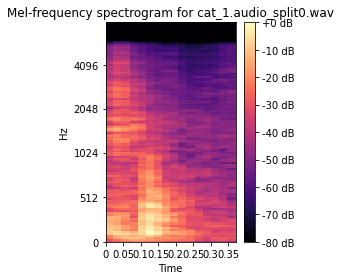

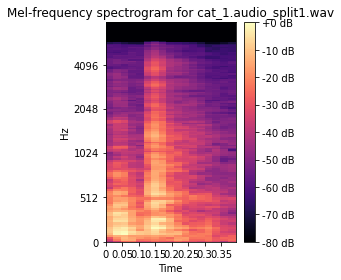

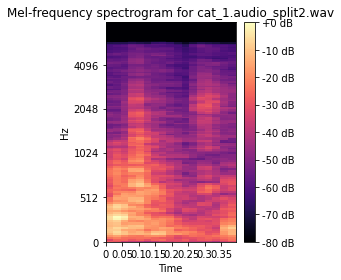

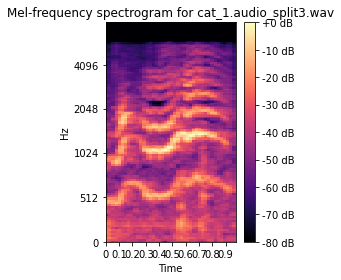

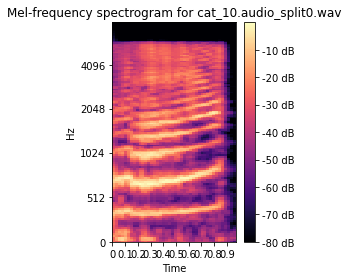

In [9]:
when = 0
for files in os.listdir("./extraction"):
    y, sr = librosa.load("./extraction/" + files)
    S = librosa.feature.melspectrogram(y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    #Display Spectrogram
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram for ' + files)
    plt.tight_layout()
    plt.show()

    # Stop after 5 displays
    when += 1
    if when == 5:
        break

### Convolving spectrograms for dataset organization

We had attempted to convolve the spectrograms and filtered spectrogram column sums array with both a smoothing and edge detecting kernel to see if it would aid in seperating tightly crammed barks for easier extraction but it was unsuccessful. Here is what convolution did to spectrograms and one can observe that it does not improve the grouping algorithm used to extract bark audio. 


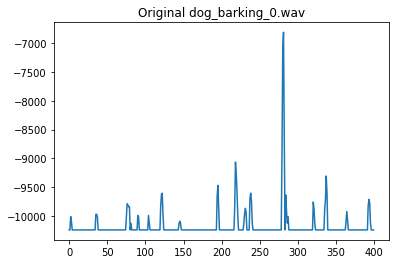

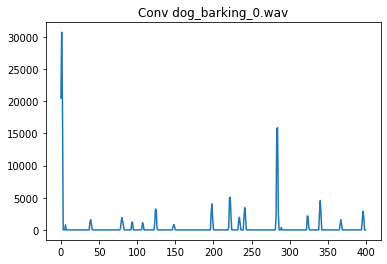

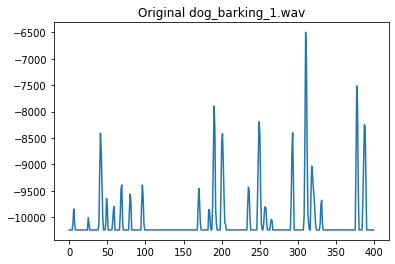

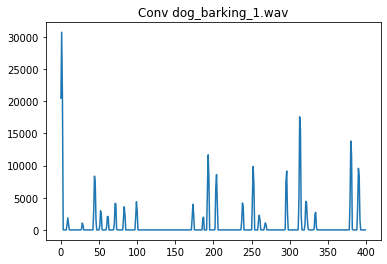

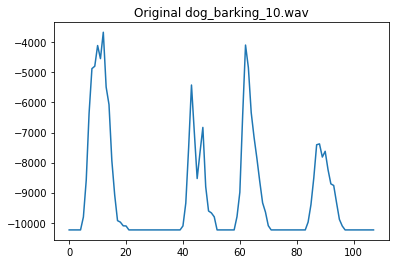

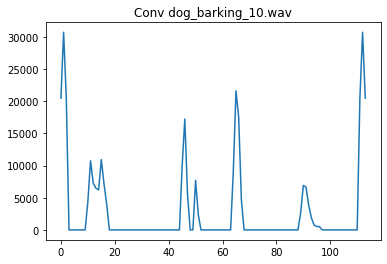

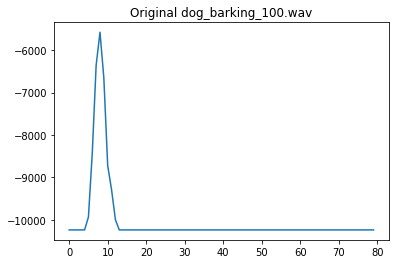

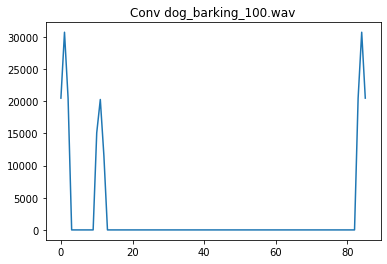

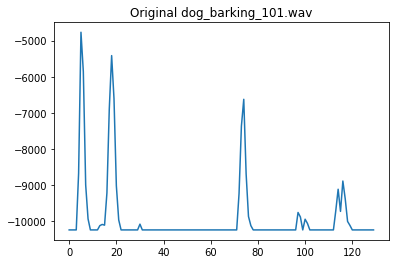

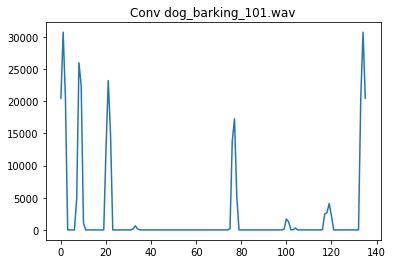

In [11]:
when = 0
for files in os.listdir("./AudioSet1"):
    # LOADING FILE
    y, sr = librosa.load("./AudioSet1/" + files)
    # y, sr = librosa.load("./AudioSet1/Leo1.wav")
    
    # SPECTROGRAM: Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr)
    # FILTERING
    win = (y.shape[0])/S.shape[1]
    avg = np.sum(S)/(S.shape[0]*S.shape[1])
    S[S < avg+30] = -80
    cols = np.sum(S, axis=0)
    minimum = -(80*128)+500
    filter = np.array([-2,-1,1,4,1,-1,-2])
    cols_conv = scipy.signal.convolve(cols[0:400],filter)
    plt.plot(cols[0:400])
    plt.title('Original ' + files)
    plt.show()
    cols_conv[cols_conv < 0] = 0
    plt.plot(cols_conv[0:400])
    plt.title('Conv ' + files)
    plt.show()
    when += 1
    if when == 3:
        break

## Part B: Feature Extraction

Here are a list of features that will be extracted from bark audio time series for production of a model:
* Mel-Spectrogram
* Mel-Spectrogram Cepstrum Coefficients [MFCC]
* Chromagram
* Zero-Crossing Rate
* Root Mean Square [RMS]
* Spectral Centroid 
* Spectral Bandwidth
* Spectral Roll-off Frequency
* Spectral Flatness
* Spectral Contrast

These features are extracted using functions provided by LibROSA saved into a dataframe and then exported into a csv file so that it can be used later and the features do not need to be recomputed.



In [7]:
columns = ['Class']
df = pd.DataFrame(data = {'File Name': [],'Mel-Spectrogram':[],'MFCCS':[],'Chromagram':[],'ZCR':[],'RMS':[],'Centroid':[],'Bandwidth':[],'Rolloff':[],'Flatness':[],'Contrast':[],'Class':[]})
dfClass = pd.read_csv('./AudioY.csv')

#If data already exists then simply read from it
# df.read_csv('./data.csv')

for files in os.listdir("./extraction"):
    # LOADING FILE
    y, sr = librosa.load("./extraction/" + files)

    #Spectrograms
    stft = librosa.stft(y=y)
    magSpec,phase = librosa.magphase(stft)
    PSpec = magSpec**2

    #Features
    melSpecF = librosa.feature.melspectrogram(S=PSpec,sr=sr)
    mfccsF = librosa.feature.mfcc(S=librosa.power_to_db(melSpecF), sr=sr)
    chromaF = librosa.feature.chroma_stft(S=PSpec,sr=sr)
    zcrF = librosa.feature.zero_crossing_rate(y)
    rmsF = librosa.feature.rms(S=magSpec)
    centroidF = librosa.feature.spectral_centroid(S=magSpec)
    bandwidthF = librosa.feature.spectral_bandwidth(S=magSpec)
    rolloffF = librosa.feature.spectral_rolloff(S=magSpec, sr=sr)
    flatnessF = librosa.feature.spectral_flatness(S=magSpec)
    contrastF = librosa.feature.spectral_contrast(S=magSpec, sr=sr)
    try:
        a = dfClass.loc[dfClass['file'] == files]['isDog'].values[0] 
    except:
        a = 0
        print(files)

    df = df.append({'File Name': files,'Mel-Spectrogram':[melSpecF],'MFCCS':[mfccsF],'Chromagram':[chromaF],'ZCR':[zcrF],\
                    'RMS':[rmsF],'Centroid':[centroidF],'Bandwidth':[bandwidthF],'Rolloff':[rolloffF],'Flatness':[flatnessF], \
                    'Contrast':[contrastF],'Class': a},ignore_index=True)

df.to_csv('data.csv',index=False)
df.head()

,File Name,Mel-Spectrogram,MFCCS,Chromagram,ZCR,RMS,Centroid,Bandwidth,Rolloff,Flatness,Contrast,Class
0,cat_1.audio_split0.wav,"[[[0.081605114, 0.27415726, 0.37067306, 0.7248...","[[[-174.08797, -132.7566, -148.43489, -189.775...","[[[0.44260418, 0.5195244, 0.61380327, 0.914224...","[[[0.05712890625, 0.0693359375, 0.09228515625,...","[[[0.04350533372709185, 0.05248008230639914, 0...","[[[1696.173829642607, 2053.1176554569934, 2066...","[[[1638.850558047503, 1735.163668761834, 1767....","[[[3477.6123046875, 3832.91015625, 3865.209960...","[[[0.0012042131, 0.0019296282, 0.00017865405, ...","[[[24.78932111419683, 22.67132100509534, 24.53...",0.0
1,cat_1.audio_split1.wav,"[[[0.0113491565, 0.0752202, 0.700552, 0.912524...","[[[-231.84723, -187.07463, -191.96774, -236.99...","[[[0.42157432, 0.47990096, 0.56462973, 0.30552...","[[[0.0234375, 0.03076171875, 0.0380859375, 0.0...","[[[0.05271412760957274, 0.10771899747059248, 0...","[[[747.4391340128179, 658.4766458025799, 584.6...","[[[1167.770597253171, 996.5790892468858, 927.2...","[[[1001.2939453125, 882.861328125, 796.7285156...","[[[6.004045e-05, 2.4595714e-05, 4.246752e-06, ...","[[[24.238794797531952, 24.151688613291366, 36....",0.0
2,cat_1.audio_split2.wav,"[[[0.4388883, 0.27127826, 0.074776135, 0.04258...","[[[-233.38127, -211.52354, -206.85669, -145.54...","[[[0.24197239, 0.13887581, 0.14025159, 0.62272...","[[[0.01953125, 0.02734375, 0.044921875, 0.0498...","[[[0.07215511081010237, 0.11218047944233098, 0...","[[[608.8946163413527, 569.0030197715497, 682.7...","[[[972.0811268962489, 839.6014957610676, 988.1...","[[[850.5615234375, 818.26171875, 904.39453125,...","[[[7.449516e-05, 4.052438e-05, 7.3596198e-06, ...","[[[23.27016707045224, 16.09866649177276, 25.49...",0.0
3,cat_1.audio_split3.wav,"[[[0.3506785, 0.09767859, 0.004927395, 0.02168...","[[[-317.00113, -316.07764, -305.13547, -259.19...","[[[0.7562876, 0.4349658, 1.0, 1.0, 1.0, 0.9111...","[[[0.0244140625, 0.044921875, 0.06982421875, 0...","[[[0.01585744922290008, 0.018256435707451505, ...","[[[917.7577530911472, 963.0720835619647, 1227....","[[[1227.7881507681118, 1169.7581973563247, 133...","[[[1582.6904296875, 1593.45703125, 1991.821289...","[[[0.00043868626, 0.00033163914, 3.9720642e-05...","[[[12.417102908296503, 11.433206264144518, 13....",0.0
4,cat_10.audio_split0.wav,"[[[0.15706544, 0.067624696, 0.09912259, 0.2881...","[[[-243.44287, -252.30043, -250.63516, -233.98...","[[[0.024809921, 0.037973713, 0.049879957, 0.07...","[[[0.03515625, 0.05029296875, 0.06884765625, 0...","[[[0.021626742441573445, 0.02386841660392464, ...","[[[1761.6207555268256, 1868.350278655555, 1837...","[[[1834.6805149050333, 1933.3561927351113, 195...","[[[3143.84765625, 3811.376953125, 4166.6748046...","[[[0.0020660518, 0.001732166, 7.949616e-05, 0....","[[[15.116359357895849, 8.610011410077233, 19.2...",0.0
5,cat_10.audio_split1.wav,"[[[0.006689459, 0.0033531224, 0.017052475, 0.0...","[[[-149.1659, -145.88129, -141.8292, -150.9547...","[[[0.41649455, 0.46940255, 0.93765557, 0.85789...","[[[0.09033203125, 0.1455078125, 0.20166015625,...","[[[0.05186481256947331, 0.06151995384102169, 0...","[[[2516.1046992585952, 2638.6619764227034, 276...","[[[1583.1517211538048, 1554.9002937733121, 150...","[[[4382.0068359375, 4392.7734375, 4414.3066406...","[[[0.0039835866, 0.00385513, 8.650587e-05, 7.5...","[[[9.811744997834214, 9.710552798686736, 18.28...",0.0
6,cat_10.audio_split2.wav,"[[[0.02238558, 0.014279621, 0.008008969, 0.002...","[[[-146.35463, -134.27327, -136.82848, -147.79...","[[[0.49359965, 0.9942341, 1.0, 0.84743285, 0.8...","[[[0.0908203125, 0.14013671875, 0.19140625, 0....","[[[0.031086951752939608, 0.039946961890908524,...","[[[2687.645971400362, 2681.0177788364613, 2747...","[[[1880.1448389819502, 1738.414753876017, 1555...","[[[4888.037109375, 4769.6044921875, 4554.27246...","[[[0.015736377, 0.012953833, 0.00015264197, 6....","[[[18.037188525815424, 11.956812051499686, 20....",0.0
7,cat_10.audio_split3.wav,"[[[0.076418236, 0.033108

In [21]:
dfa = df.copy()
feat_vals = ['Mel-Spectrogram','MFCCS','Chromagram','ZCR','RMS','Centroid','Bandwidth','Rolloff','Flatness','Contrast']
   
for item in feat_vals:
    dc = dfa[item]
    for i in range (0, dfa.shape[0]):
        dfa.loc[i,item] = np.average(dfa[item][i])

In [ ]:
def reMap(value, maxInput, minInput, maxOutput, minOutput):

	value = maxInput if value > maxInput else value
	value = minInput if value < minInput else value

	inputSpan = maxInput - minInput
	outputSpan = maxOutput - minOutput

	scaledThrust = float(value - minInput) / float(inputSpan)

	return minOutput + (scaledThrust * outputSpan)


In [1]:
xnames = ['ZCR','RMS','Centroid','Bandwidth','Rolloff','Flatness','Contrast']
for feat in itertools.combinations(xnames, 4):
    fig = plt.figure(figsize = (10,10))
    plt.title(feat[3])
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel(feat[0])
    ax.set_ylabel(feat[1])
    ax.set_zlabel(feat[2])
    min = np.min(dfa[feat[3]].to_numpy())
    max = np.max(dfa[feat[3]].to_numpy())

    for i in range(0, dfa.shape[0]):
        color = str(hex(mapping = reMap(dfa[feat[3]][i],max,min,255.0,0.0)))
        if dfa['Class'][i] == 0:
            ax.scatter(dfa[feat[0]][i],dfa[feat[1]][i], dfa[feat[2]][i], c= '#' + color + '00FF', marker='^')
        if dfa['Class'][i] == 1:
            ax.scatter(dfa[feat[0]][i], dfa[feat[1]][i], dfa[feat[2]][i], c= '#' + color + 'FF00', marker='o')
    plt.show()
    print("Output " + str(feat))


NameError: name 'itertools' is not defined

1.2451171875


### Test set and Train set splitting

We are using an 80/20 split for training/testing. The train and test sets are chosen at random.

In [13]:
np.random.permutation(dfa.shape[0])
dfa.shape[0]
# Xtr =
# ytr = 
# Xts =
# yts = 

array([ 683,  523,  757, ..., 1676,  381,  414])

In [5]:
xnames = ['ZCR','RMS','Centroid','Bandwidth','Rolloff','Flatness','Contrast']
# X = dfa[xnames].values
# print(X.shape)
# y = dfa['Class'].values
# for i in range(0, y.shape[0]):
#     if np.isnan(y[i]):
#         y[i] = 0.0

for i in itertools.combinations(xnames, 3):
    print(i[0])

# logreg = linear_model.LogisticRegression(penalty='none',solver='lbfgs')
# logreg.fit(X, y)

# betal = np.array([logreg.intercept_[0],logreg.coef_[0]])
# print(betal)

ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
ZCR
RMS
RMS
RMS
RMS
RMS
RMS
RMS
RMS
RMS
RMS
Centroid
Centroid
Centroid
Centroid
Centroid
Centroid
Bandwidth
Bandwidth
Bandwidth
Rolloff
